# Step 1: Install Dependencies (if needed)

In [1]:
!pip install pandas numpy tensorflow scikit-learn matplotlib seaborn shap


# Step 2: Load and Preprocess the Dataset

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (MSK-IMPACT dataset in TSV format)
df = pd.read_csv("/content/msk_impact_2017_clinical_data.tsv", sep='\t')

# Display first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())


          Study ID Patient ID          Sample ID         Cancer Type  \
0  msk_impact_2017  P-0000004  P-0000004-T01-IM3       Breast Cancer   
1  msk_impact_2017  P-0000015  P-0000015-T01-IM3       Breast Cancer   
2  msk_impact_2017  P-0000023  P-0000023-T01-IM3        Mesothelioma   
3  msk_impact_2017  P-0000024  P-0000024-T01-IM3  Endometrial Cancer   
4  msk_impact_2017  P-0000025  P-0000025-T01-IM3  Endometrial Cancer   

                                Cancer Type Detailed  DNA Input  \
0                   Breast Invasive Ductal Carcinoma      250.0   
1                   Breast Invasive Ductal Carcinoma      198.0   
2                            Peritoneal Mesothelioma      250.0   
3                     Uterine Endometrioid Carcinoma      250.0   
4  Uterine Serous Carcinoma/Uterine Papillary Ser...      250.0   

   Fraction Genome Altered Matched Status Metastatic Site  Mutation Count  \
0                   0.2782        Matched             NaN              16   
1         

# Step 3: Feature Selection & Mutation Classification

In [3]:
# Categorize mutation count into classes: Low (≤10), Medium (11-50), High (>50)
def categorize_mutation(x):
    if x <= 10:
        return 'Low'
    elif x <= 50:
        return 'Medium'
    else:
        return 'High'

df['Mutation Class'] = df['Mutation Count'].apply(categorize_mutation)

# Select relevant features
features = df[['TMB (nonsynonymous)', 'Fraction Genome Altered', 'Tumor Purity',
               'Cancer Type', 'Sex', 'Smoking History', 'Primary Tumor Site', 'Specimen Type']]

target = df["Mutation Class"]


# Step 4: Handle Missing Values

In [4]:
# Identify numerical and categorical columns separately
numerical_cols = ['TMB (nonsynonymous)', 'Fraction Genome Altered', 'Tumor Purity']
categorical_cols = ['Cancer Type', 'Sex', 'Smoking History', 'Primary Tumor Site', 'Specimen Type']

# Fill missing values separately
features[numerical_cols] = features[numerical_cols].apply(lambda x: x.fillna(x.median()))  # Median for numerical
features[categorical_cols] = features[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))  # Mode for categorical


<ipython-input-4-61abe088b914>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[numerical_cols] = features[numerical_cols].apply(lambda x: x.fillna(x.median()))  # Median for numerical
<ipython-input-4-61abe088b914>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[categorical_cols] = features[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))  # Mode for categorical


# Step 5: Encode Categorical Features

In [5]:
# One-hot encoding categorical columns
features = pd.get_dummies(features, columns=['Cancer Type', 'Sex', 'Smoking History', 'Primary Tumor Site', 'Specimen Type'])

# Encode target variable
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)  # Convert to numerical labels
target = to_categorical(target)  # Convert to categorical format


# Step 6: Normalize Numerical Features

In [6]:
scaler = StandardScaler()
features[['TMB (nonsynonymous)', 'Fraction Genome Altered', 'Tumor Purity']] = scaler.fit_transform(
    features[['TMB (nonsynonymous)', 'Fraction Genome Altered', 'Tumor Purity']]
)


# Step 7: Split Data into Training & Testing Sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
# Get Cancer Type column from original dataset (same split as X_test)
cancer_types_test = df.loc[X_test.index, 'Cancer Type'].values

# Step 8: Build & Train Deep Learning Model

In [10]:
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 output classes (Low, Medium, High)
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure all data is numerical
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8422 - loss: 0.4616 - val_accuracy: 0.9639 - val_loss: 0.0870
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9645 - loss: 0.0894 - val_accuracy: 0.9772 - val_loss: 0.0553
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9752 - loss: 0.0631 - val_accuracy: 0.9808 - val_loss: 0.0422
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9786 - loss: 0.0503 - val_accuracy: 0.9785 - val_loss: 0.0515
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9841 - loss: 0.0406 - val_accuracy: 0.9817 - val_loss: 0.0380
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9849 - loss: 0.0352 - val_accuracy: 0.9849 - val_loss: 0.0414
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9833 - loss: 0.0361 - val_accuracy: 0.9808 - val_loss: 0.0455
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9874 - loss: 0.0305 - val_accuracy: 0.

# Step 9: Evaluate Model Predictions

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         Low       0.97      0.89      0.93        38
      Medium       0.99      1.00      0.99      1905
        High       0.95      0.89      0.92       246

    accuracy                           0.98      2189
   macro avg       0.97      0.93      0.95      2189
weighted avg       0.98      0.98      0.98      2189



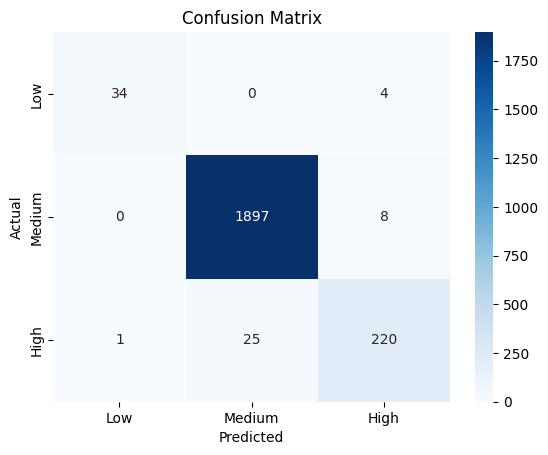

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
mutation_classes = ['Low', 'Medium', 'High']
print(classification_report(y_true, y_pred, target_names=mutation_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mutation_classes, yticklabels=mutation_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Step 10: Aggregate Predictions by Cancer Type

In [12]:
# Get Cancer Type column from original dataset (same split as X_test)
cancer_types_test = df.loc[X_test.index, 'Cancer Type'].values

# Convert numerical predictions back to labels
y_pred_labels = [mutation_classes[i] for i in y_pred]

# Create DataFrame with predictions and cancer types
results_df = pd.DataFrame({'Cancer Type': cancer_types_test, 'Predicted Mutation Type': y_pred_labels})


# Step 11: Visualizations

**1️⃣ Mutation Type Distribution per Cancer Type (Bar Chart)**

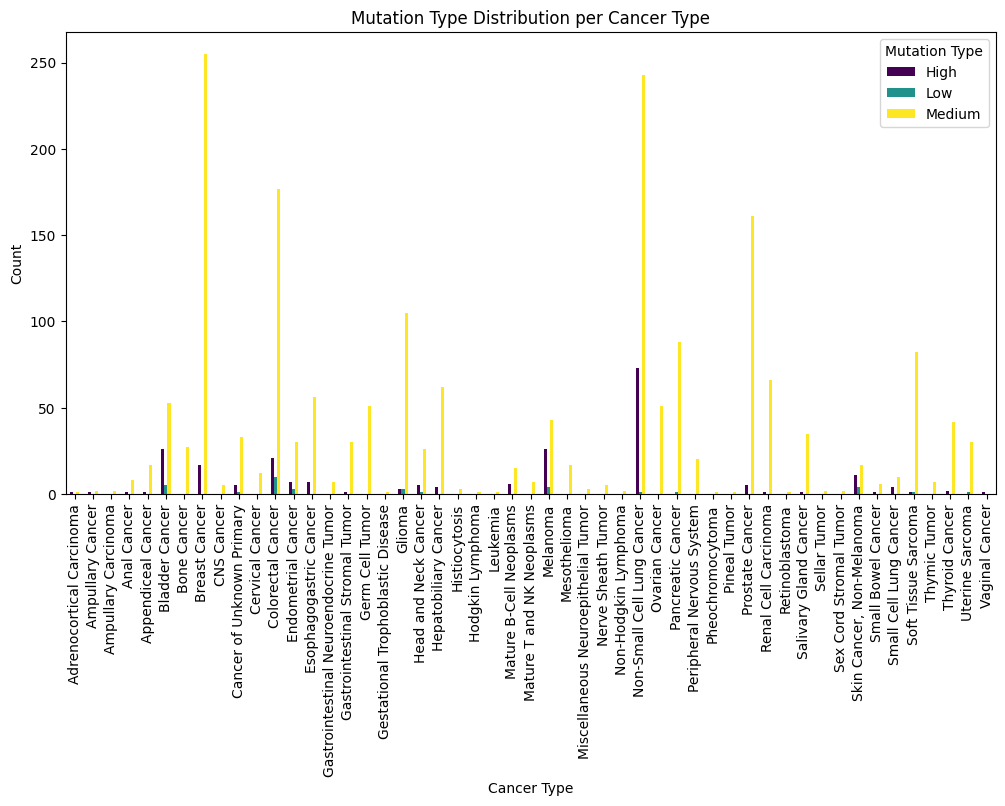

In [13]:
# Count mutation types per cancer type
mutation_counts = results_df.groupby(['Cancer Type', 'Predicted Mutation Type']).size().unstack()

# Bar chart
mutation_counts.plot(kind='bar', stacked=False, figsize=(12, 6), colormap="viridis")
plt.title("Mutation Type Distribution per Cancer Type")
plt.xlabel("Cancer Type")
plt.ylabel("Count")
plt.legend(title="Mutation Type")
plt.xticks(rotation=90)
plt.show()


**2️⃣ Proportion of Mutation Types per Cancer Type (Stacked Bar Chart)**

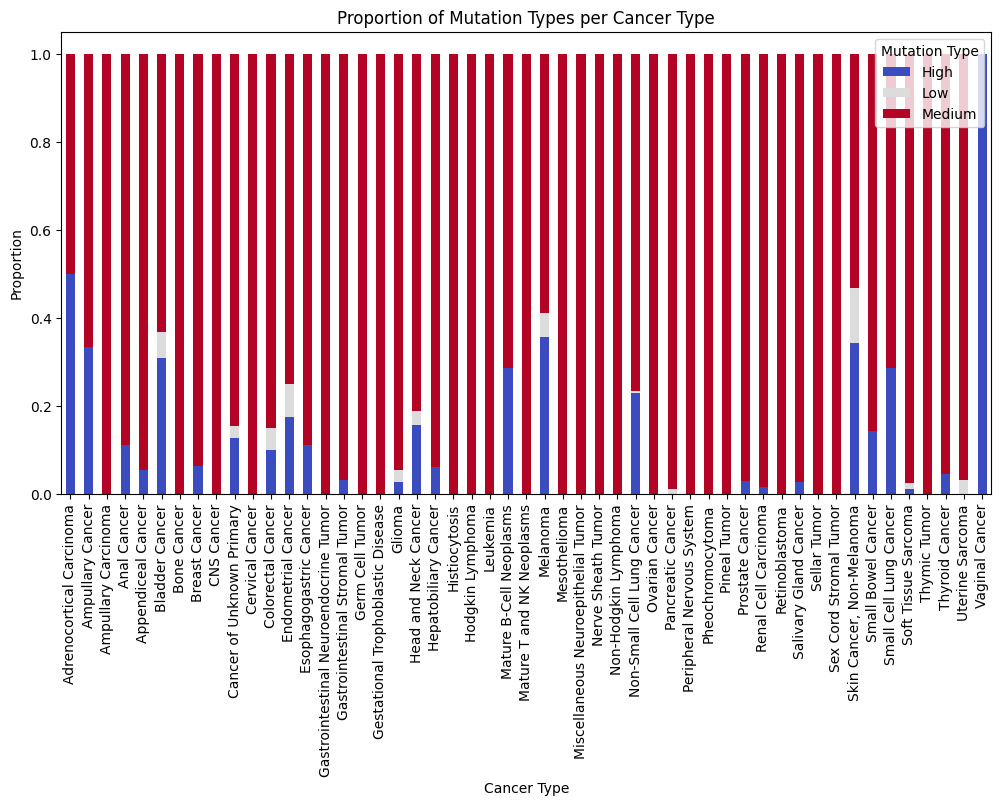

In [14]:
# Normalize counts to get proportions
mutation_counts_normalized = mutation_counts.div(mutation_counts.sum(axis=1), axis=0)

# Stacked bar chart
mutation_counts_normalized.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Mutation Types per Cancer Type")
plt.xlabel("Cancer Type")
plt.ylabel("Proportion")
plt.legend(title="Mutation Type")
plt.xticks(rotation=90)
plt.show()


**3️⃣ Pie Chart for Mutation Distribution in a Specific Cancer Type**

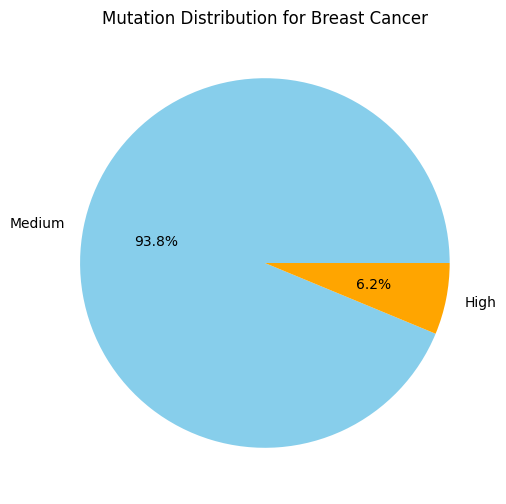

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# Choose a specific cancer type (e.g., 'Lung Cancer')
selected_cancer = "Breast Cancer"

# Filter data
cancer_data = results_df[results_df["Cancer Type"] == selected_cancer]["Predicted Mutation Type"].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(cancer_data, labels=cancer_data.index, autopct="%1.1f%%", colors=["skyblue", "orange", "red"])
plt.title(f"Mutation Distribution for {selected_cancer}")
plt.show()


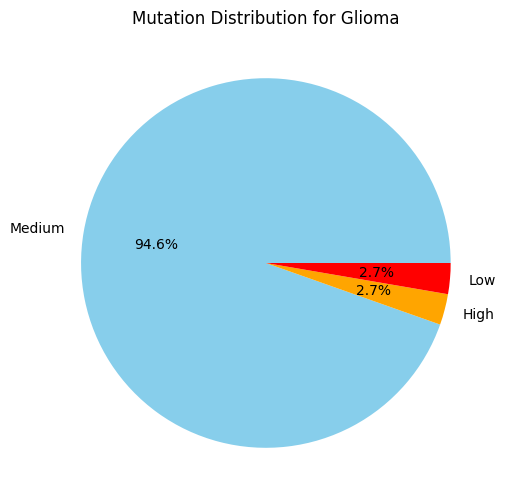

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# Choose a specific cancer type (e.g., 'Lung Cancer')
selected_cancer = "Glioma"

# Filter data
cancer_data = results_df[results_df["Cancer Type"] == selected_cancer]["Predicted Mutation Type"].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(cancer_data, labels=cancer_data.index, autopct="%1.1f%%", colors=["skyblue", "orange", "red"])
plt.title(f"Mutation Distribution for {selected_cancer}")
plt.show()


In [26]:
# Save the trained model
model.save("mutation_prediction_model.h5")
print("Model saved successfully!")


Model saved successfully!
